In [251]:
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup, SoupStrainer
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(style="whitegrid", color_codes=True)
import sys
import string
import requests
from datetime import datetime, timedelta
import time

Baksetball Reference is accessed through this url: http://www.basketball-reference.com


### Basic player information

By adding /players/'letter', we can view basic info for all active/retired NBA & ABA players with last names starting with that letter. For example, https://www.basketball-reference.com/players/a/ would give the following information for each player with last name starting with 'A':
- From: int variable, career start year
- To: int variable, career end year
- Pos: string variable, basketball position abbreviation
- Ht: string variable, height in feet-inches
- Wt: string variable, weight in pounds
- Brith Date: string variable
- Colleges: string variable, blank if international or did not play in college

In [388]:
def player_info():
    
    players = []
    player_base_url = 'http://www.basketball-reference.com/players/'

    for letter in string.ascii_lowercase: # get player tables from alphabetical list pages
        page_request = requests.get(player_base_url + letter)
        soup = BeautifulSoup(page_request.text,"lxml")
        table = soup.find('table') # find table in soup

        if table:
            table_body = table.find('tbody')
            for row in table_body.findAll('tr'):  # loop over list of players in the table
                player_url = row.find('a') 
                player_pages = player_url['href']  # player page url
                player_names = player_url.text  #p player name

                # get additional player info from table
                cells = row.findAll('td')
                active_from = int(cells[0].text) # 'From' column
                active_to = int(cells[1].text) # 'To' column
                position = cells[2].text # 'Pos' column
                height = cells[3].text # 'Ht' column (feet-inches)
                weight = cells[4].text # 'Wt' column (lbs)
                birth_date = cells[5].text # 'Birth Date' column
                college = cells[6].text # 'Colleges' column (blank is either no college or intl)

                # create entry
                player_entry = {'url': player_pages,
                                'name': player_names,
                                'active_from': active_from,
                                'active_to': active_to,
                                'pos': position,
                                'college': college,
                                'height': height,
                                'weight': weight,
                                'birth_date': birth_date}

                # append player dictionary
                players.append(player_entry)
                
    return pd.DataFrame(players)

In [389]:
players_general_df = player_info() # call function that scrapes general info

# convert height to inches
height_inches = players_general_df['height'].str.split('-',expand=True)
players_general_df['height_inches'] = 12.0*pd.to_numeric(height_inches[0], errors='coerce')+pd.to_numeric(height_inches[1], errors='coerce')

# convert birth_date to datetime
players_general_df['birth_date'] = pd.to_datetime(players_general_df['birth_date'])

players_general_df.head(10) # preview

,active_from,active_to,birth_date,college,height,name,pos,url,weight,height_inches
0,1991,1995,1968-06-24,Duke University,6-10,Alaa Abdelnaby,F-C,/players/a/abdelal01.html,240,82.0
1,1969,1978,1946-04-07,Iowa State University,6-9,Zaid Abdul-Aziz,C-F,/players/a/abdulza01.html,235,81.0
2,1970,1989,1947-04-16,"University of California, Los Angeles",7-2,Kareem Abdul-Jabbar,C,/players/a/abdulka01.html,225,86.0
3,1991,2001,1969-03-09,Louisiana State University,6-1,Mahmoud Abdul-Rauf,G,/players/a/abdulma02.html,162,73.0
4,1998,2003,1974-11-03,"University of Michigan, San Jose State University",6-6,Tariq Abdul-Wahad,F,/players/a/abdulta01.html,223,78.0
5,1997,2008,1976-12-11,University of California,6-9,Shareef Abdur-Rahim,F,/players/a/abdursh01.html,225,81.0
6,1977,1981,1954-05-06,Indiana University,6-7,Tom Abernethy,F,/players/a/abernto01.html,220,79.0
7,1957,1957,1932-07-27,Western Kentucky University,6-3,Forest Able,G,/players/a/ablefo01.html,180,75.0
8,1947,1948,1919-02-09,Salem International University,6-3,John Abramovic,F,/players/a/abramjo01.html,195,75.0
9,2017,2018,1993-08-01,,6-6,Alex Abrines,G-F,/players/a/abrinal01.html,190,78.0


In [390]:
# save in csv format
players_general_df.to_csv('Tables/players_general_df.csv', index=False)

### Detailed player information

The url of each player follows the below format:

*/players/(first letter of the last name)/(first 5 letters of last name)(first 2 letters of first name)(01 unless there's another player that fits the prior name setup, else it's 02, 03, etc).html*

Example, the end of the url for John Wall is https://www.basketball-reference.com/players/w/walljo01.html

Each player's url includes much more information (season, awards, salary, etc.), but we will focus on a couple of statistics, such as career averages.

- shooting_hand: Right or Left
- high_school: school name, city, state (or country)
- ppg: career points per game
- trb: career total rebounds per game
- ast: career assists per game
- url: player url page

In [391]:
players_general_df = pd.read_csv('Tables/players_general_df.csv')

In [376]:
def player_detail_info(url):
    '''
    scrape player's personal page. Input is players url (without  www.basketball-reference.com)
    '''
    # we do not need to parse the whole page since the information we are interested in is only a small part
    personal = SoupStrainer('p')
    page_request = requests.get('http://www.basketball-reference.com' + url)
    soup = BeautifulSoup(page_request.text, "lxml", parse_only=personal) # parse only part we are interested in
    p = soup.findAll('p') 

    # initialize some values in case they are unavailable
    position = None
    shooting_hand = None
    high_school = None
    draft = None
    ppg = None
    trb = None
    ast = None

    # loop over personal info to get certain information
    for prow in p:
        if 'Shoots:' in prow.text:
            s = prow.text.replace('\n','').split(u'\u25aa') # clean text
            if len(s)>1:
                shoots = s[1].split(':')[1].lstrip().rstrip()
                position = s[0].split(':')[1].lstrip().rstrip() # if multiple positions, read first listed position
                if 'and' in position:
                    position = position.split('and')[0].lstrip().rstrip()
        elif 'High School:' in prow.text:
            s = prow.text.replace('\n','').split(':') 
            if len(s)>1:
                high_school = s[1].lstrip()
        elif 'Draft:' in prow.text:
            s = prow.text.replace('\n','').split(':')
            if len(s)>1:
                draft = s[1].lstrip()
        elif 'Career' in prow.text:
            s = prow.find_next_siblings('p')[3]
            ppg = float(str(s).strip('"<p>""</p>"'))
            s = prow.find_next_siblings('p')[5]
            trb = float(str(s).strip('"<p>""</p>"'))            
            s = prow.find_next_siblings('p')[7]
            ast = float(str(s).strip('"<p>""</p>"'))  

    # create dictionary with all of the info            
    player_entry = {'position': position,
                    'shooting_hand': shoots,
                    'high_school': high_school,
                    'draft': draft,
                    'ppg' : ppg,
                    'trb' : trb,
                    'ast' : ast,
                    'url': url}

    return player_entry

In [381]:
players_details_info_list = []
for i,url in enumerate(players_general_df.url):
    try:
        players_details_info_list.append(player_detail_info(url))
    except:
        pass

In [384]:
players_detail_df = pd.DataFrame(players_details_info_list) # convert to dateframe 
players_detail_df.head() # preview

,ast,draft,high_school,position,ppg,shooting_hand,trb,url
0,0.3,"Portland Trail Blazers, 1st round (25th pick, ...","Bloomfield in Bloomfield, New Jersey",Power Forward,5.7,Right,3.3,/players/a/abdelal01.html
1,1.2,"Cincinnati Royals, 1st round (5th pick, 5th ov...","John Jay in Brooklyn, New York",Center,9.0,Right,8.0,/players/a/abdulza01.html
2,3.6,"Milwaukee Bucks, 1st round (1st pick, 1st over...","Power Memorial in New York, New York",Center,24.6,Right,11.2,/players/a/abdulka01.html
3,3.5,"Denver Nuggets, 1st round (3rd pick, 3rd overa...","Gulfport in Gulfport, Mississippi",Point Guard,14.6,Right,1.9,/players/a/abdulma02.html
4,1.1,"Sacramento Kings, 1st round (11th pick, 11th o...","Lycee Aristide Briand in Evreux, France",Shooting Guard,7.8,Right,3.3,/players/a/abdulta01.html


In [385]:
# split high school into state
def split_hs(hsString):
    '''
    splits high_school value into high school name and state
    '''
    if hsString:
        s = hsString.split(' in ')[1].split(',')
        if len(s)==2:
            city = s[0].lstrip().rstrip()
            state = s[1].lstrip().rstrip()
            name = hsString.split(' in ')[0]
    else:
        city = None
        state = None
        name = None
    return pd.Series([city, state, name], index=['city','state','name'])

# now apply the function
players_detail_df[['hs_city','hs_state','hs_name']] = players_detail_df['high_school'].apply(split_hs)
players_detail_df.head() # preview

,ast,draft,high_school,position,ppg,shooting_hand,trb,url,hs_city,hs_state,hs_name
0,0.3,"Portland Trail Blazers, 1st round (25th pick, ...","Bloomfield in Bloomfield, New Jersey",Power Forward,5.7,Right,3.3,/players/a/abdelal01.html,Bloomfield,New Jersey,Bloomfield
1,1.2,"Cincinnati Royals, 1st round (5th pick, 5th ov...","John Jay in Brooklyn, New York",Center,9.0,Right,8.0,/players/a/abdulza01.html,Brooklyn,New York,John Jay
2,3.6,"Milwaukee Bucks, 1st round (1st pick, 1st over...","Power Memorial in New York, New York",Center,24.6,Right,11.2,/players/a/abdulka01.html,New York,New York,Power Memorial
3,3.5,"Denver Nuggets, 1st round (3rd pick, 3rd overa...","Gulfport in Gulfport, Mississippi",Point Guard,14.6,Right,1.9,/players/a/abdulma02.html,Gulfport,Mississippi,Gulfport
4,1.1,"Sacramento Kings, 1st round (11th pick, 11th o...","Lycee Aristide Briand in Evreux, France",Shooting Guard,7.8,Right,3.3,/players/a/abdulta01.html,Evreux,France,Lycee Aristide Briand


In [443]:
# covert swingman positions into traditional five basketball positions
players_detail_df['position'] =  players_detail_df['position'].map({'Guard/Forward': 'Point Guard',
                                                                    'Point Guard': 'Point Guard',
                                                                    'Guard': 'Point Guard',
                                                                    'Shooting Guard': 'Shooting Guard',
                                                                    'Small Forward': 'Small Forward',
                                                                    'Forward/Guard': 'Small Forward',
                                                                    'Forward': 'Small Forward',
                                                                    'Power Forward': 'Power Forward',
                                                                    'Forward/Center': 'Power Forward',
                                                                    'Center': 'Center',
                                                                    'Center/Forward': 'Center'
                                                                    })

In [447]:
# save in csv format
players_detail_df.to_csv('Tables/players_detail_df.csv', index=False)

In [448]:
players_detail_df = pd.read_csv('Tables/players_detail_df.csv')

### Merge two dataframes

In [449]:
# merge two dataframes: players_general_info and players_detail_df
players_merged_df = players_general_df.merge(players_detail_df,how='outer',on='url')

# convert swingman positions into traditional positions (guard, forward, center)
players_merged_df['trad_position'] = players_merged_df['position'].map({'Point Guard': 'Guard',
                                                                        'Shooting Guard': 'Guard',
                                                                        'Small Forward': 'Forward',
                                                                        'Power Forward': 'Forward',
                                                                        'Center': 'Center'})

# reorganize columns
players_merged_df = players_merged_df[['name', 'active_from', 'active_to', 'birth_date',
                                        'position', 'trad_position', 'ppg', 'trb', 'ast', 'height_inches', 'weight', 
                                        'shooting_hand', 'college', 'hs_name', 'hs_city', 'hs_state', 'url']]

#preview
players_merged_df.head()

,name,active_from,active_to,birth_date,position,trad_position,ppg,trb,ast,height_inches,weight,shooting_hand,college,hs_name,hs_city,hs_state,url
0,Alaa Abdelnaby,1991,1995,1968-06-24,Power Forward,Forward,5.7,3.3,0.3,82.0,240.0,Right,Duke University,Bloomfield,Bloomfield,New Jersey,/players/a/abdelal01.html
1,Zaid Abdul-Aziz,1969,1978,1946-04-07,Center,Center,9.0,8.0,1.2,81.0,235.0,Right,Iowa State University,John Jay,Brooklyn,New York,/players/a/abdulza01.html
2,Kareem Abdul-Jabbar,1970,1989,1947-04-16,Center,Center,24.6,11.2,3.6,86.0,225.0,Right,"University of California, Los Angeles",Power Memorial,New York,New York,/players/a/abdulka01.html
3,Mahmoud Abdul-Rauf,1991,2001,1969-03-09,Point Guard,Guard,14.6,1.9,3.5,73.0,162.0,Right,Louisiana State University,Gulfport,Gulfport,Mississippi,/players/a/abdulma02.html
4,Tariq Abdul-Wahad,1998,2003,1974-11-03,Shooting Guard,Guard,7.8,3.3,1.1,78.0,223.0,Right,"University of Michigan, San Jose State University",Lycee Aristide Briand,Evreux,France,/players/a/abdulta01.html


In [450]:
# save in csv format
players_merged_df.to_csv('Tables/players_merged_df.csv', index=False)

### Data visualization

In [451]:
players_merged_df = pd.read_csv('Tables/players_merged_df.csv')

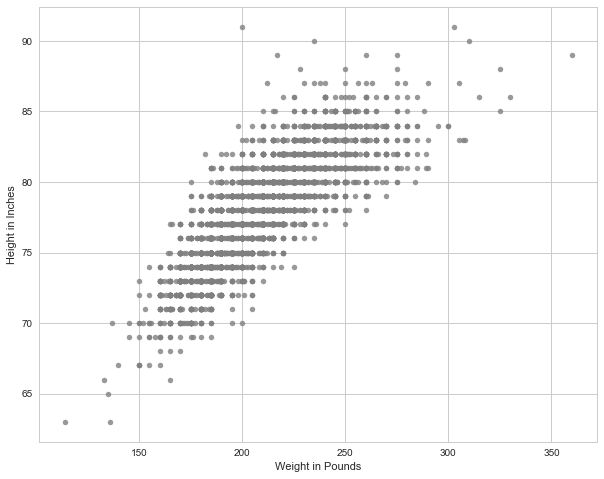

In [452]:
plt.figure(figsize=(10,8))

ax = sns.regplot(x='weight', y='height_inches', data=players_merged_df, color='grey', fit_reg=False, scatter_kws={"s": 30})
ax.set(xlabel='Weight in Pounds', ylabel='Height in Inches')
plt.show()

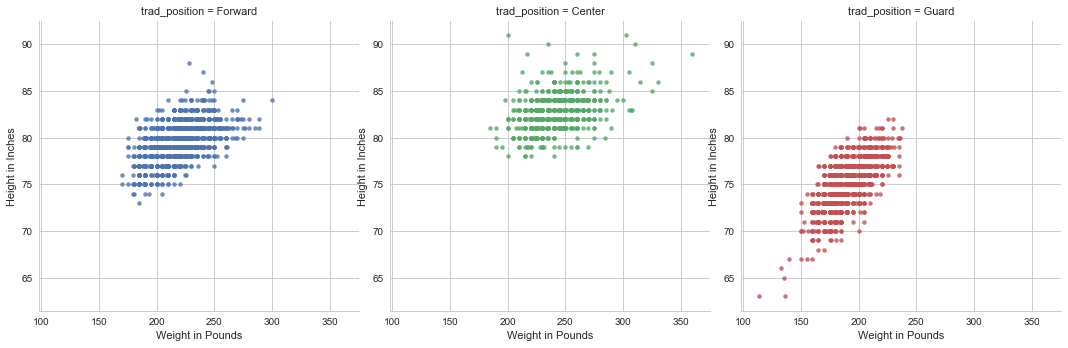

In [461]:
ax = sns.lmplot(x="weight", y="height_inches", data=players_merged_df, 
               col='trad_position', hue='trad_position',
               x_jitter=.1, fit_reg=False, scatter_kws={"s": 20})
ax.set(xlabel='Weight in Pounds', ylabel='Height in Inches')


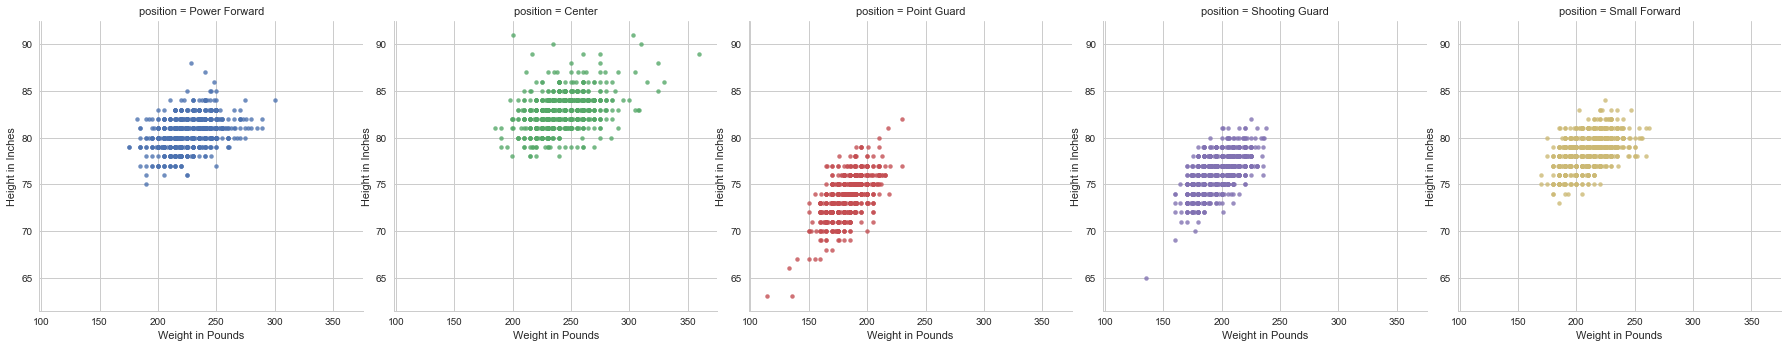

In [456]:
ax = sns.lmplot(x="weight", y="height_inches", data=players_merged_df, 
               col='position', hue='position',
               x_jitter=.1, fit_reg=False, scatter_kws={"s": 20})
ax.set(xlabel='Weight in Pounds', ylabel='Height in Inches')